In [43]:
import pandas as pd
import numpy as np
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.isotonic import IsotonicRegression

In [23]:
# fin_features = ["ORGAN_isKP", "MED_COND_TRR_is3", "CREAT_TRR", "AGE", "AGE_DON", "WGT_KG_CALC", "PA_PRESERV_TM", "AFT", "COX", 
#                 "time_frame", "GRF_STAT_PA"]

In [ ]:
train = pd.read_csv("train_aft.csv")
test = pd.read_csv("test_aft.csv")


# train = train[fin_features]
# test = test[fin_features]

train = train.drop(columns=["AFT", "COX"])
test = test.drop(columns=["AFT", "COX"])

# train["time_frame"] = train["time_frame"] / 12
# test["time_frame"] = test["time_frame"] / 12

y_train = Surv.from_dataframe("GRF_STAT_PA", "time_frame", train)
y_test = Surv.from_dataframe("GRF_STAT_PA", "time_frame", test)

X_train = train.drop(columns=["GRF_STAT_PA", "time_frame"], axis=1)
X_test = test.drop(columns=["GRF_STAT_PA", "time_frame"], axis=1)


In [26]:
rsf = RandomSurvivalForest(n_estimators=500, max_depth=14, max_features="sqrt", min_samples_leaf=50, min_samples_split=100, bootstrap=True, verbose=1, n_jobs=-1, random_state=42)

In [27]:
weights = np.where(y_train["GRF_STAT_PA"] == 1, 75.0, 1.0)  # Event: 2x weight, Censored: 1x weight

In [28]:
rsf.fit(X_train, y_train, sample_weight=weights)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.9min finished


RandomSurvivalForest(max_depth=14, min_samples_leaf=50, min_samples_split=100,
                     n_estimators=500, n_jobs=-1, random_state=42, verbose=1)

In [29]:
rsf.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   30.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  1.3min finished


0.6511070318396951

In [30]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# ============================ Predict Survival Function ============================
pred_survival = rsf.predict_survival_function(X_test)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   18.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   44.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   51.7s finished


In [ ]:

# ============================ Extract Median Survival Times ============================
predicted_median_times = []
for survival_func in pred_survival:
    time_points = survival_func.x  # Extract time grid from StepFunction
    survival_probs = survival_func.y  # Extract corresponding survival probabilities

    # Find the first time where survival probability drops below 50%
    if (survival_probs  0.7).any():
        median_time = time_points[np.where(survival_probs <= 0.5)[0][0]]
    else:
        median_time = time_points[-1]  # If never below 50%, assign max time

    predicted_median_times.append(median_time)

# ============================ Compute MAE ============================
mae_rsf = mean_absolute_error(y_test["time_frame"], predicted_median_times)
print(f"Mean Absolute Error (MAE) for RSF Model: {mae_rsf:.4f}")


Mean Absolute Error (MAE) for RSF Model: 1273.4773


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   22.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   51.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   59.1s finished


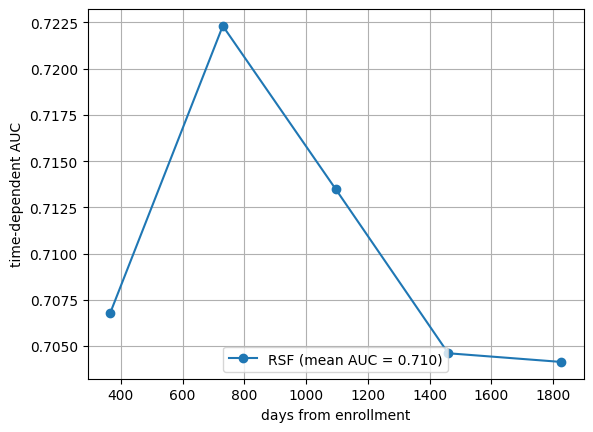

In [32]:
import matplotlib.pyplot as plt
from sksurv.metrics import cumulative_dynamic_auc



y_train = pd.DataFrame(y_train, columns=["GRF_STAT_PA", "time_frame"])
y_test = pd.DataFrame(y_test, columns=["GRF_STAT_PA", "time_frame"])

y_train["GRF_STAT_PA"] = y_train["GRF_STAT_PA"].astype("bool")
y_test["GRF_STAT_PA"] = y_test["GRF_STAT_PA"].astype("bool")

# Prepare survival objects for train and test data
y_test_surv = Surv.from_dataframe("GRF_STAT_PA", "time_frame", data=y_test)
y_train_surv = Surv.from_dataframe("GRF_STAT_PA", "time_frame", data=y_train)


times = np.arange(365, 365*5+1, 365)

rsf_scores = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_surv = np.vstack([chf(times) for chf in rsf_scores])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train_surv, y_test_surv, rsf_surv, times)


plt.plot(times, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)




In [33]:
from sksurv.metrics import integrated_brier_score, brier_score
import numpy as np

# Define the time points at which to compute the Brier score
surv_funcs = rsf.predict_survival_function(X_test)

times_2 = np.arange(365, 365*5+1, 365)

# Convert survival functions into probabilities at specific time points
preds_ibs = np.asarray([[fn(t) for t in times_2] for fn in surv_funcs])


# Compute Brier Score at specific times
brier_scores = brier_score(y_train_surv, y_test_surv, preds_ibs, times_2)
print(f"Brier Scores: {brier_scores}")

# Compute the Integrated Brier Score (IBS) over the specified time points
ibs = integrated_brier_score(y_train_surv, y_test_surv, preds_ibs, times_2)
print(f"Integrated Brier Score (IBS): {ibs}")


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   20.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   47.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   54.3s finished


Brier Scores: (array([ 365,  730, 1095, 1460, 1825]), array([0.04409589, 0.08418313, 0.13023586, 0.17050777, 0.2089051 ]))
Integrated Brier Score (IBS): 0.12785681376985988


In [34]:
from sklearn.inspection import permutation_importance

In [35]:
# perm_imp = permutation_importance(rsf, X_test, y_test_surv, n_repeats=5)

In [36]:
perm_mean = pd.DataFrame(perm_imp["importances_mean"])
perm_std = pd.DataFrame(perm_imp["importances_std"])
perm_cols = pd.DataFrame(X_test.columns)

NameError: name 'perm_imp' is not defined

In [ ]:
perm_df = pd.concat([perm_cols, perm_mean, perm_std], axis=1)

In [ ]:
perm_df.columns = ["var", "mean", "std"]

In [ ]:
perm_df["perm_rvi"] = perm_df["mean"] / sum(perm_df["mean"])

In [ ]:
perm_df["rvi_dumb"] = perm_df["mean"] / max(perm_df["mean"])

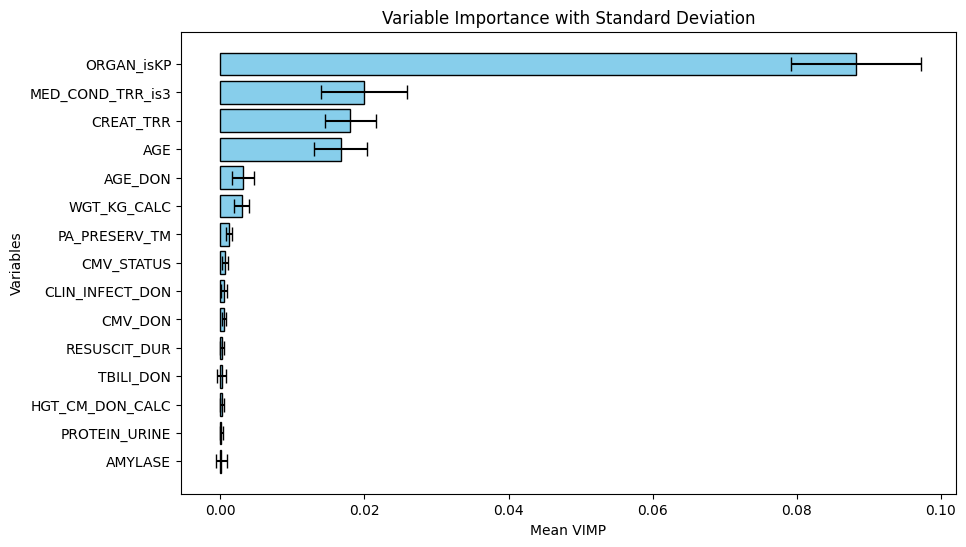

In [ ]:
import matplotlib.pyplot as plt

# Sort by mean VIMP for better visualization
df = perm_df.sort_values(by="mean", ascending=False).head(15)

# Plot with error bars
plt.figure(figsize=(10, 6))
plt.barh(df["var"], df["mean"], xerr=df["std"], capsize=5, color="skyblue", edgecolor="black")
plt.xlabel("Mean VIMP")
plt.ylabel("Variables")
plt.title("Variable Importance with Standard Deviation")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


In [ ]:
df

,var,mean,std,perm_rvi,rvi_dumb
18,ORGAN_isKP,0.088225,0.009006,0.621915,1.000000
22,MED_COND_TRR_is3,0.019917,0.005924,0.140397,0.225750
1,CREAT_TRR,0.018050,0.003589,0.127238,0.204592
13,AGE,0.016698,0.003635,0.117709,0.189268
2,AGE_DON,0.003163,0.001552,0.022297,0.035853
24,WGT_KG_CALC,0.002954,0.001009,0.020825,0.033485
15,PA_PRESERV_TM,0.001199,0.000478,0.008454,0.013593
21,CMV_STATUS,0.000654,0.000407,0.004611,0.007415
9,CLIN_INFECT_DON,0.000500,0.000439,0.003524,0.005667
4,CMV_DON,0.000468,0.000284,0.003297,0.005302
